In [1]:
import pandas as pd
import numpy as np
import pickle

import time
from datetime import datetime


In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.cluster import MeanShift, estimate_bandwidth

import warnings
warnings.filterwarnings("ignore")

In [3]:

# Load Train dataset
patient_df = pd.read_csv("data/patient_df.csv", index_col=0)
patient_df.head(5).append(patient_df.tail(5))

,Id,FilledScripts,RefilledScripts,ProvidersFilledScripts,DurationOfAppointments,Nsaids,Opioids,SaboxoneBuprenorphine,Benzodiazepines,Mme,...,Dast10,Soapp,Qol,Audit,CliexaDiagnosticScore,CliexaDiagnosticRisk,CalculatorRiskOutput,Diagnosis,HasPredicted,CreatedOn
0,2036,5,6,2,16,False,True,TRUE,True,17.69,...,NaN,4,NaN,NaN,15,High,High,NaN,False,2023-02-22 23:00:00+00:00
1,3012,5,4,2,6,True,True,pastOnly,False,11.95,...,NaN,12,NaN,NaN,10,High,High,NaN,False,2023-02-22 23:00:00+00:00
2,2306,2,0,2,10,True,True,FALSE,False,17.56,...,7.0,20,NaN,NaN,7,High,High,NaN,False,2023-02-22 23:00:00+00:00
3,2766,5,1,3,11,True,True,FALSE,True,6.87,...,8.0,16,NaN,NaN,10,High,High,NaN,False,2023-02-22 23:00:00+00:00
4,2027,5,4,0,16,False,True,FALSE,True,13.55,...,5.0,7,99.0,9.0,10,High,High,NaN,False,2023-02-22 23:00:00+00:00
1020,3047,0,0,0,0,True,NaN,NaN,True,0.00,...,0.0,0,99.0,0.0,3,Low,Low,NaN,False,2023-02-22 23:00:00+00:00
1021,3048,0,0,0,0,True,NaN,NaN,NaN,0.00,...,0.0,0,NaN,NaN,0,Low,Very Low,NaN,False,2023-02-22 23:00:00+00:00
1022,3049,0,0,0,0,True,True,TRUE,NaN,0.00,...,0.0,0,92.0,0.0,9,High,Low,NaN,False,2023-02-22 23:00:00+00:00
1023,3050,0,0,0,0,NaN,NaN,NaN,True,0.00,...,0.0,0,100.0,0.0,3,Low,Low,NaN,False,2023-02-22 23:00:00+00:00
1024,3051,0,0,0,0,True,NaN,TRUE,True,0.00,...,0.0,0,100.0,0.0,7,High,Low,NaN,False,2023-02-22 23:00:00+00:00


In [4]:
patient_df[patient_df['Age'] == 100].iloc[:,10:25].head()

,Ua,Depression,Anxiety,Ptsd,SleepApnea,Ra,Copd,Age,Gender,Race,Bmi,Timezone,SocioEconomic,Alcohol,DrugUse
310,abnormal,noHistory,noHistory,familyHistory,NaN,NaN,NaN,100.0,F,black,26.76,south,middle,current,noHistory
320,normal,familyHistory,pastMedicalHistory,NaN,NaN,NaN,pastMedicalHistory,100.0,M,white,34.59,westNorthEast,lower,current,current
459,normal,familyHistory,both,NaN,NaN,noHistory,noHistory,100.0,M,black,22.57,south,lower,former,noHistory
675,abnormal,noHistory,NaN,pastMedicalHistory,NaN,NaN,NaN,100.0,M,black,33.54,westNorthEast,middle,frequent,current
676,normal,both,pastMedicalHistory,both,familyHistory,pastMedicalHistory,pastMedicalHistory,100.0,F,black,22.30,midWest,upper,frequent,noHistory


In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
patient_df = reduce_mem_usage(patient_df)
patient_df.dtypes

Mem. usage decreased to  0.24 Mb (33.7% reduction)


Id                          int16
FilledScripts                int8
RefilledScripts              int8
ProvidersFilledScripts       int8
DurationOfAppointments       int8
Nsaids                     object
Opioids                    object
SaboxoneBuprenorphine      object
Benzodiazepines            object
Mme                       float16
Ua                         object
Depression                 object
Anxiety                    object
Ptsd                       object
SleepApnea                 object
Ra                         object
Copd                       object
Age                       float16
Gender                     object
Race                       object
Bmi                       float16
Timezone                   object
SocioEconomic              object
Alcohol                    object
DrugUse                    object
SmokingStatus              object
EmploymentStatus           object
MedicationAdherence       float16
DietFruitsAndVeggies       object
DietHighSalt  

In [7]:
patient_df.iloc[:,:15].tail(10)

,Id,FilledScripts,RefilledScripts,ProvidersFilledScripts,DurationOfAppointments,Nsaids,Opioids,SaboxoneBuprenorphine,Benzodiazepines,Mme,Ua,Depression,Anxiety,Ptsd,SleepApnea
1015,3042,0,0,0,0,True,NaN,TRUE,NaN,0.0,normal,NaN,noHistory,noHistory,noHistory
1016,3043,0,0,0,0,True,True,TRUE,NaN,0.0,normal,NaN,noHistory,noHistory,noHistory
1017,3044,0,0,0,0,NaN,True,TRUE,NaN,0.0,normal,NaN,noHistory,noHistory,NaN
1018,3045,0,0,0,0,True,True,TRUE,True,0.0,normal,NaN,noHistory,NaN,noHistory
1019,3046,0,0,0,0,True,NaN,TRUE,NaN,0.0,normal,NaN,NaN,noHistory,noHistory
1020,3047,0,0,0,0,True,NaN,NaN,True,0.0,normal,noHistory,noHistory,NaN,NaN
1021,3048,0,0,0,0,True,NaN,NaN,NaN,0.0,normal,noHistory,noHistory,NaN,NaN
1022,3049,0,0,0,0,True,True,TRUE,NaN,0.0,normal,noHistory,noHistory,NaN,noHistory
1023,3050,0,0,0,0,NaN,NaN,NaN,True,0.0,normal,noHistory,noHistory,noHistory,noHistory
1024,3051,0,0,0,0,True,NaN,TRUE,True,0.0,normal,noHistory,NaN,NaN,NaN


In [8]:
bool_list = ['Nsaids', 'Opioids', 'Benzodiazepines']
bool_dict = {True: 3, False: 1}
for i in bool_list:
    patient_df[i].fillna(value=999, inplace=True)
    patient_df[i] = patient_df[i].replace(bool_dict.keys(), bool_dict.values())

patient_df.iloc[:,:15].tail(10)

,Id,FilledScripts,RefilledScripts,ProvidersFilledScripts,DurationOfAppointments,Nsaids,Opioids,SaboxoneBuprenorphine,Benzodiazepines,Mme,Ua,Depression,Anxiety,Ptsd,SleepApnea
1015,3042,0,0,0,0,3,999,TRUE,999,0.0,normal,NaN,noHistory,noHistory,noHistory
1016,3043,0,0,0,0,3,3,TRUE,999,0.0,normal,NaN,noHistory,noHistory,noHistory
1017,3044,0,0,0,0,999,3,TRUE,999,0.0,normal,NaN,noHistory,noHistory,NaN
1018,3045,0,0,0,0,3,3,TRUE,3,0.0,normal,NaN,noHistory,NaN,noHistory
1019,3046,0,0,0,0,3,999,TRUE,999,0.0,normal,NaN,NaN,noHistory,noHistory
1020,3047,0,0,0,0,3,999,NaN,3,0.0,normal,noHistory,noHistory,NaN,NaN
1021,3048,0,0,0,0,3,999,NaN,999,0.0,normal,noHistory,noHistory,NaN,NaN
1022,3049,0,0,0,0,3,3,TRUE,999,0.0,normal,noHistory,noHistory,NaN,noHistory
1023,3050,0,0,0,0,999,999,NaN,3,0.0,normal,noHistory,noHistory,noHistory,noHistory
1024,3051,0,0,0,0,3,999,TRUE,3,0.0,normal,noHistory,NaN,NaN,NaN


In [9]:
patient_df.SaboxoneBuprenorphine.value_counts()

TRUE        350
pastOnly    344
FALSE       321
Name: SaboxoneBuprenorphine, dtype: int64

In [10]:
SaboxoneBuprenorphine_dict = {'TRUE': 5, 'FALSE': 1, 'pastOnly': 3}
patient_df['SaboxoneBuprenorphine'].fillna(value=999, inplace=True)
patient_df['SaboxoneBuprenorphine'] = patient_df['SaboxoneBuprenorphine'].replace(SaboxoneBuprenorphine_dict.keys(), SaboxoneBuprenorphine_dict.values())
patient_df.SaboxoneBuprenorphine.value_counts()

5      350
3      344
1      321
999     10
Name: SaboxoneBuprenorphine, dtype: int64

In [11]:
ua_dict = {'normal': 1, 'abnormal': 5}
patient_df['Ua'].fillna(value=999, inplace=True)
patient_df['Ua'] = patient_df['Ua'].replace(ua_dict.keys(), ua_dict.values())
patient_df.Ua.value_counts()

1    555
5    470
Name: Ua, dtype: int64

In [12]:
co_morbidities_list = ['Depression', 'Anxiety', 'Ptsd', 'SleepApnea', 'Ra', 'Copd']
co_morbidities_dict = {'familyHistory': 1, 'noHistory': 0, 'both': 5, 'pastMedicalHistory': 3}

for i in co_morbidities_list:
    patient_df[i].fillna(value=999, inplace=True)
    patient_df[i] = patient_df[i].replace(co_morbidities_dict.keys(), co_morbidities_dict.values())
#patient_df.Depression.value_counts()

In [13]:
gender_dict = {'F': 3, 'M': 1, 'Other': 0}
patient_df["Gender"].fillna(value='Other', inplace=True)
patient_df["Gender"] = patient_df["Gender"].astype(object)
patient_df["Gender"] = patient_df["Gender"].replace(gender_dict.keys(), gender_dict.values())
patient_df.Gender.value_counts()

3    470
1    450
0    105
Name: Gender, dtype: int64

In [14]:
patient_df = pd.concat([patient_df, pd.get_dummies(patient_df["Timezone"],prefix="timezone_in_")], axis=1)
patient_df.drop(columns=["Timezone"], axis=1, inplace=True)

In [15]:
patient_df.iloc[:,10:25].tail(10)

,Ua,Depression,Anxiety,Ptsd,SleepApnea,Ra,Copd,Age,Gender,Race,Bmi,SocioEconomic,Alcohol,DrugUse,SmokingStatus
1015,1,999,0,0,0,0,0,95.0,1,white,17.921875,upper,noHistory,noHistory,noHistory
1016,1,999,0,0,0,0,999,96.0,3,white,12.476562,upper,noHistory,noHistory,NaN
1017,1,999,0,0,999,999,0,83.0,1,white,14.960938,upper,noHistory,noHistory,noHistory
1018,1,999,0,999,0,0,0,96.0,3,white,15.062500,upper,noHistory,noHistory,noHistory
1019,1,999,999,0,0,999,0,70.0,1,white,24.812500,upper,noHistory,noHistory,noHistory
1020,1,0,0,999,999,0,999,93.0,3,white,17.218750,upper,noHistory,noHistory,noHistory
1021,1,0,0,999,999,0,0,NaN,1,NaN,11.992188,upper,noHistory,noHistory,noHistory
1022,1,0,0,999,0,999,999,96.0,3,white,15.476562,upper,NaN,noHistory,NaN
1023,1,0,0,0,0,0,0,85.0,1,white,24.406250,upper,NaN,noHistory,noHistory
1024,1,0,999,999,999,999,0,94.0,1,white,22.437500,upper,noHistory,noHistory,noHistory


In [16]:
bins_methods = [ "auto", "fd", "doane", "scott", "stone", "rice", "sturges", "sqrt"]

def get_columns_bins(column_name):
    all_bins = []
  
    for method in bins_methods:
        start = datetime.now()
        hist, bin_edges = np.histogram(column_name,bins=method)
        all_bins.append(bin_edges)
        print("Method : {:<7} - Running Time : {:<5} - Number of bins : {:<5} - Head : {} - Tail : {}".format(method,str(datetime.now()-start), len(bin_edges), bin_edges[:3], bin_edges[-3:-1]))
    return all_bins



def get_clustering_bins(s, quantile=0.3, n_samples=None):
    
    series = s.dropna().values.reshape(-1, 1)
    
    bandwidth = estimate_bandwidth(series, quantile=quantile, n_samples=n_samples)
    clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(series)

    d = pd.DataFrame(columns=['data_column', 'label_column'])

    d['data_column'] = series.reshape(-1)
    d['label_column'] = clustering.labels_
    
    sorted_vals = d.groupby('label_column')['data_column'].max().sort_values().values
    bins = np.insert(sorted_vals, [0] , [series.min()-1])
    bins[-1] = bins[-1] + 1
    
    return bins, range(bins.size-1)


In [17]:
patient_df['Age'].min(), patient_df['Age'].max(), patient_df['Age'].mean()

(1.0, 100.0, 51.44)

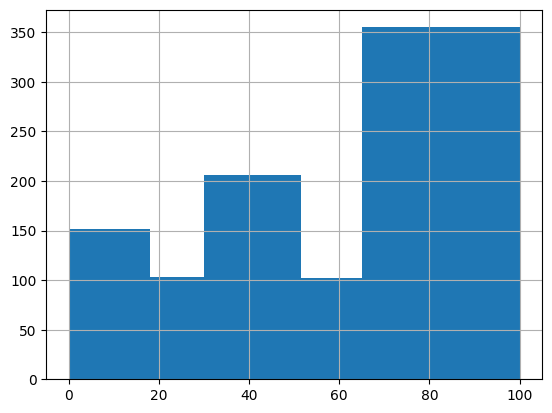

In [18]:
age_bins = [0, 18, 30, patient_df['Age'].mean(), 65, patient_df['Age'].max()]
patient_df.Age.hist(bins=age_bins)

In [19]:
len(age_bins),patient_df.Age.value_counts(bins=age_bins)


(6,
 (65.0, 100.0]     340
 (30.0, 51.438]    200
 (-0.001, 18.0]    165
 (51.438, 65.0]    117
 (18.0, 30.0]       96
 Name: Age, dtype: int64)

In [20]:
patient_df['Age'] = pd.cut(patient_df.Age, age_bins).cat.codes
patient_df.head(5).append(patient_df.tail(5))

,Id,FilledScripts,RefilledScripts,ProvidersFilledScripts,DurationOfAppointments,Nsaids,Opioids,SaboxoneBuprenorphine,Benzodiazepines,Mme,...,Audit,CliexaDiagnosticScore,CliexaDiagnosticRisk,CalculatorRiskOutput,Diagnosis,HasPredicted,CreatedOn,timezone_in__midWest,timezone_in__south,timezone_in__westNorthEast
0,2036,5,6,2,16,1,3,5,3,17.687500,...,NaN,15,High,High,NaN,False,2023-02-22 23:00:00+00:00,0,0,0
1,3012,5,4,2,6,3,3,3,1,11.953125,...,NaN,10,High,High,NaN,False,2023-02-22 23:00:00+00:00,0,0,0
2,2306,2,0,2,10,3,3,1,1,17.562500,...,NaN,7,High,High,NaN,False,2023-02-22 23:00:00+00:00,0,0,0
3,2766,5,1,3,11,3,3,1,3,6.871094,...,NaN,10,High,High,NaN,False,2023-02-22 23:00:00+00:00,0,0,0
4,2027,5,4,0,16,1,3,1,3,13.546875,...,9.0,10,High,High,NaN,False,2023-02-22 23:00:00+00:00,0,0,1
1020,3047,0,0,0,0,3,999,999,3,0.000000,...,0.0,3,Low,Low,NaN,False,2023-02-22 23:00:00+00:00,0,0,1
1021,3048,0,0,0,0,3,999,999,999,0.000000,...,NaN,0,Low,Very Low,NaN,False,2023-02-22 23:00:00+00:00,0,0,0
1022,3049,0,0,0,0,3,3,5,999,0.000000,...,0.0,9,High,Low,NaN,False,2023-02-22 23:00:00+00:00,0,0,1
1023,3050,0,0,0,0,999,999,999,3,0.000000,...,0.0,3,Low,Low,NaN,False,2023-02-22 23:00:00+00:00,0,0,1
1024,3051,0,0,0,0,3,999,5,3,0.000000,...,0.0,7,High,Low,NaN,False,2023-02-22 23:00:00+00:00,0,0,1


In [21]:
patient_df.Race.value_counts()

white    346
black    287
other    285
Name: Race, dtype: int64

In [22]:
patient_df["Race"].fillna(value='other', inplace=True)


In [23]:
patient_df = pd.concat([patient_df, pd.get_dummies(patient_df["Race"],prefix="race_")], axis=1)
patient_df.drop(columns=["Race"], axis=1, inplace=True)

In [24]:
patient_df.shape

(1025, 51)

In [25]:
patient_df.EmploymentStatus.value_counts()

fullTime      352
partTime      338
unemployed    330
Name: EmploymentStatus, dtype: int64

In [26]:
social_list = ['Alcohol', 'DrugUse', 'SmokingStatus']
social_dict = {'noHistory' : 0, 'frequent' : 7, 'current' : 5, 'former' : 3}

for i in social_list:
    patient_df[i].fillna(value=999, inplace=True)
    patient_df[i] = patient_df[i].replace(social_dict.keys(), social_dict.values())

In [27]:
patient_df.SocioEconomic.value_counts()

lower     319
upper     318
middle    281
Name: SocioEconomic, dtype: int64

In [28]:
SocioEconomic_dict = {'lower' : 1, 'middle' : 3, 'upper' : 5}
patient_df['SocioEconomic'].fillna(value=0, inplace=True)
patient_df['SocioEconomic'] = patient_df['SocioEconomic'].replace(SocioEconomic_dict.keys(), SocioEconomic_dict.values())

In [29]:
EmploymentStatus_dict = {'fullTime' : 1, 'partTime' : 3, 'unemployed' : 5}
patient_df['EmploymentStatus'].fillna(value=0, inplace=True)
patient_df['EmploymentStatus'] = patient_df['EmploymentStatus'].replace(EmploymentStatus_dict.keys(), EmploymentStatus_dict.values())

In [30]:
patient_df.MedicationAdherence.value_counts()

54.0000    24
64.0000    22
43.0000    20
98.0000    20
85.0000    20
           ..
92.9375     1
97.3750     1
96.2500     1
94.6875     1
95.1875     1
Name: MedicationAdherence, Length: 83, dtype: int64

In [31]:
patient_df['MedicationAdherence'].fillna(value=0, inplace=True)
patient_df['MedicationAdherence'] = np.where((patient_df['MedicationAdherence'] < 60), 1, 
                          np.where((patient_df['MedicationAdherence'] >= 90), 5, 3))

patient_df.MedicationAdherence.value_counts()


3    438
1    406
5    181
Name: MedicationAdherence, dtype: int64

In [32]:
#MedicationAdherence	DietFruitsAndVeggies	DietHighSalt	DietProcessedFood
diet_list = ['DietFruitsAndVeggies', 'DietHighSalt', 'DietProcessedFood']
diet_dict = {False : 0, True : 5, 'other' : 999}

for i in diet_list:
    patient_df[i].fillna(value='other', inplace=True)
    patient_df[i] = patient_df[i].replace(diet_dict.keys(), diet_dict.values())

In [33]:
patient_df.iloc[:,30:45].head()

,Engagement,Phq9,Gad7,Ort,Peg,Dast10,Soapp,Qol,Audit,CliexaDiagnosticScore,CliexaDiagnosticRisk,CalculatorRiskOutput,Diagnosis,HasPredicted,CreatedOn
0,0.0,NaN,NaN,2,10.0,NaN,4,NaN,NaN,15,High,High,NaN,False,2023-02-22 23:00:00+00:00
1,4.0,10.0,NaN,2,NaN,NaN,12,NaN,NaN,10,High,High,NaN,False,2023-02-22 23:00:00+00:00
2,2.0,11.0,NaN,1,7.0,7.0,20,NaN,NaN,7,High,High,NaN,False,2023-02-22 23:00:00+00:00
3,5.0,7.0,NaN,2,6.0,8.0,16,NaN,NaN,10,High,High,NaN,False,2023-02-22 23:00:00+00:00
4,1.0,5.0,1.0,4,10.0,5.0,7,99.0,9.0,10,High,High,NaN,False,2023-02-22 23:00:00+00:00


In [34]:
pros_list = ['Engagement', 'Phq9', 'Gad7', 'Ort', 'Peg', 'Dast10', 'Soapp', 'Qol', 'Audit']
for i in pros_list:
    patient_df[i].fillna(value=0, inplace=True)


In [35]:
diagnosis_list = [True,False]

patient_df["Diagnosis"] = np.random.choice(diagnosis_list, size=len(patient_df))

In [36]:
patient_df["Diagnosis"].value_counts()

False    527
True     498
Name: Diagnosis, dtype: int64

In [37]:
patient_df.columns

Index(['Id', 'FilledScripts', 'RefilledScripts', 'ProvidersFilledScripts',
       'DurationOfAppointments', 'Nsaids', 'Opioids', 'SaboxoneBuprenorphine',
       'Benzodiazepines', 'Mme', 'Ua', 'Depression', 'Anxiety', 'Ptsd',
       'SleepApnea', 'Ra', 'Copd', 'Age', 'Gender', 'Bmi', 'SocioEconomic',
       'Alcohol', 'DrugUse', 'SmokingStatus', 'EmploymentStatus',
       'MedicationAdherence', 'DietFruitsAndVeggies', 'DietHighSalt',
       'DietProcessedFood', 'Activity', 'Engagement', 'Phq9', 'Gad7', 'Ort',
       'Peg', 'Dast10', 'Soapp', 'Qol', 'Audit', 'CliexaDiagnosticScore',
       'CliexaDiagnosticRisk', 'CalculatorRiskOutput', 'Diagnosis',
       'HasPredicted', 'CreatedOn', 'timezone_in__midWest',
       'timezone_in__south', 'timezone_in__westNorthEast', 'race__black',
       'race__other', 'race__white'],
      dtype='object')

In [38]:
patient_df['Activity'].fillna(value=0, inplace=True)


In [39]:
drop_list = ['CliexaDiagnosticScore', 'CliexaDiagnosticRisk', 'CalculatorRiskOutput', 'HasPredicted', 'CreatedOn']
patient_df = patient_df.drop(columns=drop_list)


In [40]:
X = patient_df.drop(columns=["Diagnosis"])
y = patient_df["Diagnosis"]
#os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((922, 45), (103, 45), (922,), (103,))

In [41]:
X_train_list = X_train.columns[X_train.isna().any()].tolist()
X_train_list

[]

## Random Forest


In [42]:
%%time

n_estimators = [200, 700]
max_depth = [5, 8]
min_samples_split = [10, 100]
min_samples_leaf = [5, 10]
hyper_random = {"n_estimators":n_estimators,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "min_samples_leaf":min_samples_leaf}

clf_rf_tuned = GridSearchCV(RandomForestClassifier(), hyper_random, 
                            cv = 5, verbose = 1, 
                            n_jobs = -1)
clf_rf_tuned.fit(X_train, y_train)
best_params_random = clf_rf_tuned.best_params_
print(best_params_random)


CV_clf_rf = RandomForestClassifier(max_depth=best_params_random["max_depth"],
                                   min_samples_leaf=best_params_random["min_samples_leaf"],
                                   min_samples_split=best_params_random["min_samples_split"],
                                   n_estimators= best_params_random["n_estimators"])
CV_clf_rf.fit(X_train, y_train)
y_test_predict_proba_random = CV_clf_rf.predict_proba(X_test)[:, 1]
yhat_random = CV_clf_rf.predict(X_test)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba_random, n_bins=10)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   28.7s finished


{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 100, 'n_estimators': 200}
CPU times: user 773 ms, sys: 40.5 ms, total: 814 ms
Wall time: 29.3 s


In [43]:
# save the model to disk
filename = 'random_forest_model.sav'
pickle.dump(clf_rf_tuned, open(filename, 'wb'))

In [44]:
%%time
# Create a corrected classifier.

clf_sigmoid = CalibratedClassifierCV(CV_clf_rf, cv=10, method='sigmoid')
clf_sigmoid.fit(X_train, y_train)
y_test_predict_proba_sigmoid_calibrated = clf_sigmoid.predict_proba(X_test)[:, 1]
yhat_calibrated_sigmoid = clf_sigmoid.predict(X_test)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba_sigmoid_calibrated, n_bins=10)


CPU times: user 3.19 s, sys: 19.8 ms, total: 3.21 s
Wall time: 3.21 s


In [45]:
# save the model to disk
filename = 'calibrated_sigmoid_model.sav'
pickle.dump(clf_sigmoid, open(filename, 'wb'))

In [46]:
print(classification_report(y_test, yhat_random))


              precision    recall  f1-score   support

       False       0.49      0.67      0.57        51
        True       0.50      0.33      0.40        52

    accuracy                           0.50       103
   macro avg       0.50      0.50      0.48       103
weighted avg       0.50      0.50      0.48       103



In [47]:
print(classification_report(y_test, yhat_calibrated_sigmoid))


              precision    recall  f1-score   support

       False       0.50      0.80      0.62        51
        True       0.52      0.21      0.30        52

    accuracy                           0.50       103
   macro avg       0.51      0.51      0.46       103
weighted avg       0.51      0.50      0.46       103



## Gaussian Naive Bayes


In [48]:
%%time
# Uncalibrated
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
y_test_predict_proba_nb = clf_nb.predict_proba(X_test)[:, 1]
yhat_nb = clf_nb.predict(X_test)
fraction_of_positives_nb, mean_predicted_value_nb = calibration_curve(y_test, y_test_predict_proba_nb, n_bins=10)

#plt.plot(mean_predicted_value_nb, fraction_of_positives_nb, 's-', label='Uncalibrated')

# Calibrated
clf_isotonic_nb = CalibratedClassifierCV(clf_nb, cv=10, method='isotonic')
clf_isotonic_nb.fit(X_train, y_train)
y_test_predict_proba_isotonic_calib = clf_isotonic_nb.predict_proba(X_test)[:, 1]
yhat_calibrated_isotonic = clf_isotonic_nb.predict(X_test)
fraction_of_positives_isotonic_calib, mean_predicted_value_isotonic_calib = calibration_curve(y_test, y_test_predict_proba_isotonic_calib, n_bins=10)

#plt.plot(mean_predicted_value_nb_calib, fraction_of_positives_nb_calib, 's-', color='red', label='Calibrated (Isotonic)')

# Calibrated, Platt
clf_sigmoid_nb_calib_sig = CalibratedClassifierCV(clf_nb, cv=10, method='sigmoid')
clf_sigmoid_nb_calib_sig.fit(X_train, y_train)

y_test_predict_proba_sigmoid_calib_platt = clf_sigmoid_nb_calib_sig.predict_proba(X_test)[:, 1]
yhat_calibrated_sigmoid_platt = clf_sigmoid_nb_calib_sig.predict(X_test)

fraction_of_positives_nb_calib_platt, mean_predicted_value_nb_calib_platt = calibration_curve(y_test, y_test_predict_proba_sigmoid_calib_platt, n_bins=10)
#plt.plot(mean_predicted_value_nb_calib_platt, fraction_of_positives_nb_calib_platt, 's-', color='orange', label='Calibrated (Platt)')


CPU times: user 65.1 ms, sys: 3.86 ms, total: 69 ms
Wall time: 68.5 ms


In [49]:
# save the model to disk
filename = 'gaussian_nb_model.sav'
pickle.dump(clf_nb, open(filename, 'wb'))

In [50]:
# save the model to disk
filename = 'clf_isotonic_nb_model.sav'
pickle.dump(clf_isotonic_nb, open(filename, 'wb'))

In [52]:
# save the model to disk
filename = 'clf_sigmoid_nb_model.sav'
pickle.dump(clf_sigmoid_nb_calib_sig, open(filename, 'wb'))

In [53]:
print(classification_report(y_test, yhat_nb))


              precision    recall  f1-score   support

       False       0.60      0.12      0.20        51
        True       0.52      0.92      0.66        52

    accuracy                           0.52       103
   macro avg       0.56      0.52      0.43       103
weighted avg       0.56      0.52      0.43       103



In [54]:
print(classification_report(y_test, yhat_calibrated_isotonic))


              precision    recall  f1-score   support

       False       0.47      0.51      0.49        51
        True       0.48      0.44      0.46        52

    accuracy                           0.48       103
   macro avg       0.48      0.48      0.48       103
weighted avg       0.48      0.48      0.48       103



In [55]:
print(classification_report(y_test, yhat_calibrated_sigmoid_platt))


              precision    recall  f1-score   support

       False       0.45      0.76      0.57        51
        True       0.25      0.08      0.12        52

    accuracy                           0.42       103
   macro avg       0.35      0.42      0.34       103
weighted avg       0.35      0.42      0.34       103



## SVM

In [56]:
%%time
#hyper_svm = {"kernel": ["linear", "poly", "rbf", "sigmoid"],
#           "C": [1, 100, 1000],
#           "gamma": [1, 0.1, 0.00001]}


hyper_svm = {"kernel": ["rbf"],
           "C": [1],
           "gamma": [1]}
clf_svm_tuned = GridSearchCV(SVC(probability=True), 
                             hyper_svm,
                             cv=3,
                             verbose=1,
                             n_jobs=6)

clf_svm_tuned.fit(X_train, y_train)
best_params_svm = clf_svm_tuned.best_params_
print(best_params_svm)


CV_clf_svm = SVC(kernel=best_params_svm["kernel"],
                 C=best_params_svm["C"],
                 gamma=best_params_svm["gamma"],
                 probability=True)

CV_clf_svm.fit(X_train, y_train)
y_test_predict_proba_svm = CV_clf_svm.predict_proba(X_test)[:, 1]
yhat_svm = CV_clf_svm.predict(X_test)
fraction_of_positives_svm, mean_predicted_value_svm = calibration_curve(y_test, y_test_predict_proba_svm, n_bins=10)



Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    1.4s finished


{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
CPU times: user 642 ms, sys: 53.2 ms, total: 695 ms
Wall time: 2.19 s


In [57]:
# save the model to disk
filename = 'svm_model.sav'
pickle.dump(CV_clf_svm, open(filename, 'wb'))

In [58]:
%%time
# Create a corrected classifier.
clf_sigmoid_svm = CalibratedClassifierCV(CV_clf_svm, cv=10, method='sigmoid')
clf_sigmoid_svm.fit(X_train, y_train)
y_test_predict_proba_svm_sigmoid_calibrated = clf_sigmoid_svm.predict_proba(X_test)[:, 1]
yhat_calibrated_sigmoid_svm = clf_sigmoid_svm.predict(X_test)
fraction_of_positives_svm_calibrated, mean_predicted_value_svm_calibrated = calibration_curve(y_test, y_test_predict_proba_svm_sigmoid_calibrated, n_bins=10)



CPU times: user 2.58 s, sys: 0 ns, total: 2.58 s
Wall time: 2.59 s


In [59]:
# save the model to disk
filename = 'clf_sigmoid_svm_model.sav'
pickle.dump(clf_sigmoid_svm, open(filename, 'wb'))

In [60]:
print(classification_report(y_test, yhat_svm))


              precision    recall  f1-score   support

       False       0.50      1.00      0.66        51
        True       0.00      0.00      0.00        52

    accuracy                           0.50       103
   macro avg       0.25      0.50      0.33       103
weighted avg       0.25      0.50      0.33       103



In [61]:
print(classification_report(y_test, yhat_calibrated_sigmoid_svm))

              precision    recall  f1-score   support

       False       0.50      1.00      0.66        51
        True       0.00      0.00      0.00        52

    accuracy                           0.50       103
   macro avg       0.25      0.50      0.33       103
weighted avg       0.25      0.50      0.33       103

